# Mixture of Gaussian for anomaly detectoin

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13
import warnings
warnings.filterwarnings("ignore")

In [2]:
def generator (mean_x,mean_y,var_x,var_y):
    mean = [mean_x, mean_y]
    cov = [[var_x, 0], [0, var_y]]  
    x, y = np.random.multivariate_normal(mean, cov, 500).T
    Results=np.concatenate((x[:,np.newaxis],y[:,np.newaxis]),axis=1)
    return(Results)
def generator_N (mean_x,mean_y,var_x,var_y):
    mean = [mean_x, mean_y]
    cov = [[var_x, 0], [0, var_y]]  
    x, y = np.random.multivariate_normal(mean, cov, 10).T
    Results=np.concatenate((x[:,np.newaxis],y[:,np.newaxis]),axis=1)
    return(Results)

In [3]:
Gauss1=generator(5,5,0.1,0.1)
Gauss2=generator(8,8,0.1,0.1)
Gauss3=generator(5,8,0.1,0.1)
Gauss4=generator(8,5,0.1,0.1)

In [4]:
Rawdata=np.concatenate((Gauss1,Gauss2,Gauss3,Gauss4),axis=0)

## Multi modal의 형태라면?

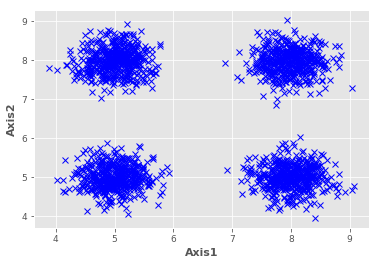

In [5]:
plt.xlabel('Axis1')
plt.ylabel('Axis2')
plt.plot(Rawdata[:,0],Rawdata[:,1],'bx')
plt.show()

### Abnormal dataset을 만들어보자

In [6]:
Axis1_Reference=np.array([3.5,6.5,9.5])
Axis2_Reference=np.array([3.5,6.5,9.5])

Append_Novelty=np.empty([0,2])

for i in range(len(Axis1_Reference)):
    for j in range(len(Axis2_Reference)):        
        TMP = generator_N(Axis1_Reference[i],Axis2_Reference[j],0.05,0.05)
        Append_Novelty = np.concatenate((Append_Novelty,TMP))       

In [7]:
np.shape(Append_Novelty)

(90, 2)

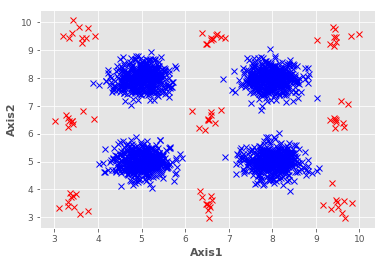

In [8]:
plt.xlabel('Axis1')
plt.ylabel('Axis2')
plt.plot(Rawdata[:,0],Rawdata[:,1],'bx')
plt.plot(Append_Novelty[:,0],Append_Novelty[:,1],'rx')
plt.show()

In [9]:
print(np.shape(Rawdata))
print(np.shape(Append_Novelty))

(2000, 2)
(90, 2)


#### Data shuffle

In [10]:
Num_Rawdata=np.shape(Rawdata)[0]
Num_Noveltydata=np.shape(Append_Novelty)[0]

In [11]:
Rawdata = Rawdata[np.random.choice(Num_Rawdata,Num_Rawdata),:]
Append_Novelty = Append_Novelty[np.random.choice(Num_Noveltydata,Num_Noveltydata),:]

In [12]:
TR_Dataset = np.concatenate((Rawdata[:1500,:],Append_Novelty[:30,:]))
VL_Dataset = np.concatenate((Rawdata[1500:1800,:],Append_Novelty[30:60,:]))
TE_Dataset = np.concatenate((Rawdata[1800:2000,:],Append_Novelty[60:90,:]))

VL_Label = np.concatenate((np.repeat(0,300),np.repeat(1,30)))
TE_Label = np.concatenate((np.repeat(0,200),np.repeat(1,30)))

### Single gaussian 이라면..

In [13]:
# 데이터 셋의 피쳐를 정규화하는 함수
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

# 가우시안 분포 추정 함수
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
# 다변량 가우시안에서 pdf를 리턴하는 함수
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

# 교차검증을 통해 가장 좋은 epsilon(임계치) 탐색
def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon) 
        f = f1_score(gt, predictions,average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon

In [14]:
mu, sigma = estimateGaussian(TR_Dataset)

In [15]:
mu

array([6.48616211, 6.49870062])

In [16]:
sigma

array([[ 2.40569808e+00, -9.30161499e-04],
       [-9.30161499e-04,  2.40985485e+00]])

In [17]:
p = multivariateGaussian(VL_Dataset,mu,sigma)

In [18]:
#selecting optimal value of epsilon using validation dataset
p_cv = multivariateGaussian(VL_Dataset,mu,sigma)
fscore, ep = selectThresholdByCV(p_cv,VL_Label)
print(fscore, ep)

0.847457627118644 0.011675985257966436


In [19]:
#selecting outlier datapoints 
outliers = np.asarray(np.where(p < ep))

### 붉은색 부분은 Single gaussian가정의 한계로 탐지하지 못하게 됨

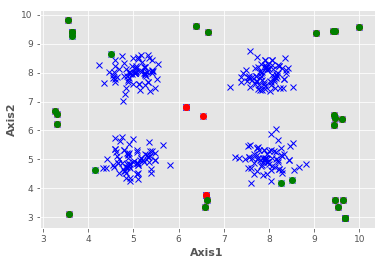

In [20]:
plt.figure()
plt.xlabel('Axis1')
plt.ylabel('Axis2')
plt.plot(VL_Dataset[:,0],VL_Dataset[:,1],'bx')
plt.plot(VL_Dataset[301:330,0],VL_Dataset[301:330,1],'ro')
plt.plot(VL_Dataset[outliers,0],VL_Dataset[outliers,1],'go')
plt.show()

# Mixture of gaussian

In [21]:
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=4,covariance_type='full')
clf.fit(TR_Dataset)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [22]:
x = np.linspace(1., 12.)
y = np.linspace(1., 12.)
X, Y = np.meshgrid(x, y) # meshgrid는 좌표로 combination해주는 것
XX = np.array([X.ravel(), Y.ravel()]).T # reshape에서 flatten해주는 것
Z = -clf.score_samples(XX) 
Z = Z.reshape(X.shape)

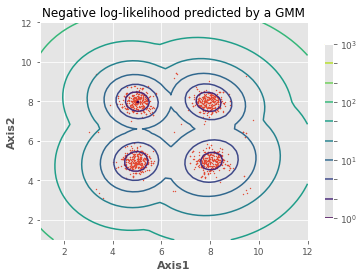

In [23]:
from matplotlib.colors import LogNorm
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(TR_Dataset[:, 0], TR_Dataset[:, 1], .8)
plt.title('Negative log-likelihood predicted by a GMM')
plt.xlabel('Axis1')
plt.ylabel('Axis2')
plt.axis('tight')
plt.show()

In [24]:
x = np.linspace(1., 12.)

In [25]:
np.shape(Z)

(50, 50)

In [26]:
# 교차검증을 통해 가장 좋은 epsilon(임계치) 탐색
def selectThresholdByGMM(NL,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(NL) - min(NL)) / 1000;
    epsilons = np.arange(min(NL)+0.001,max(NL),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (NL > epsilon) 
        f = f1_score(gt, predictions,average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon    
    return best_f1, best_epsilon

In [27]:
#selecting optimal value of epsilon using validation dataset

fscore, ep = selectThresholdByCV(p_cv,VL_Label)
print(fscore, ep)

#print(VL_Label)

#selecting outlier datapoints 
outliers = np.asarray(np.where(p_cv > ep))
#print(outliers)

0.847457627118644 0.011675985257966436


In [28]:
Z = -clf.score_samples(VL_Dataset) 
fscore, ep = selectThresholdByGMM(Z,VL_Label)
print(fscore, ep)

#selecting outlier datapoints 
outliers = np.asarray(np.where(Z > ep))

1.0 5.974200815217708


### 이제 모든 경우의 수를 잘 찾는것을 확인 할 수 있음

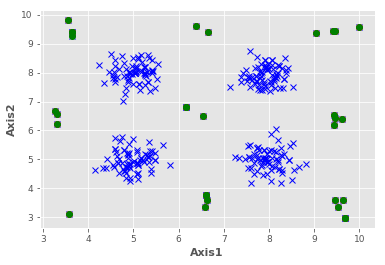

In [29]:
plt.figure()
plt.xlabel('Axis1')
plt.ylabel('Axis2')
plt.plot(VL_Dataset[:,0],VL_Dataset[:,1],'bx')
plt.plot(VL_Dataset[301:330,0],VL_Dataset[301:330,1],'ro')
plt.plot(VL_Dataset[outliers,0],VL_Dataset[outliers,1],'go')
plt.show()

### 이제 Test dataset에 대하여 적용해 보자

In [30]:
Z = -clf.score_samples(TE_Dataset) 
outliers = np.asarray(np.where(Z > ep))

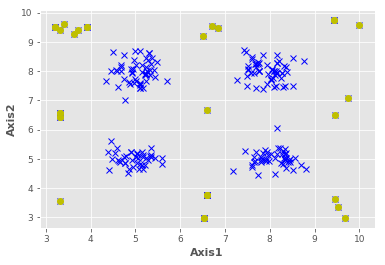

In [31]:
plt.figure()
plt.xlabel('Axis1')
plt.ylabel('Axis2')
plt.plot(TE_Dataset[:,0],TE_Dataset[:,1],'bx')
plt.plot(TE_Dataset[200:230,0],TE_Dataset[200:230,1],'yo')
plt.show()

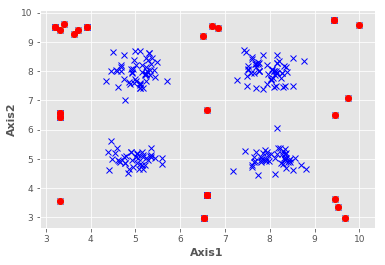

In [32]:
plt.figure()
plt.xlabel('Axis1')
plt.ylabel('Axis2')
plt.plot(TE_Dataset[:,0],TE_Dataset[:,1],'bx')
plt.plot(TE_Dataset[200:230,0],TE_Dataset[200:230,1],'yo')
plt.plot(TE_Dataset[outliers,0],TE_Dataset[outliers,1],'ro')
plt.show()

#### 다음 Isolation forest, Local Outlier Factor, Autoencoder based novelty detection을 위하여
#### 데이터를 저장하자

In [33]:
Multi_Modal_Data={'TR_Input' : TR_Dataset ,'VL_Input' : VL_Dataset, 
                  'TE_Input' : TE_Dataset ,'VL_Output' : VL_Label ,
                  'TE_Output' : TE_Label }

In [34]:
## save
#import pickle
#with open('./data/Multi_Modal.pickle', 'wb') as f:
#    pickle.dump(Multi_Modal_Data, f, pickle.HIGHEST_PROTOCOL)